In [1]:
import pandas as pd
import numpy as np
import yaml
import sys

sys.path.append('../../')
from dataset import PdaVideos, collate_video
import transforms as my_transforms
from train_pda_cv import evaluate

import models
import timm
import copy
import torch
from torch.utils.data import DataLoader


In [2]:
artifact_folder = '/project/dane2/wficai/pda/model_run_artifacts/pda_numheads_4'
frame_csv = '/project/dane2/wficai/pda/external_validation/CHOC_echo_images/pda_train_val_test.csv'
checkpoint = 'model_checkpoint_video.ckpt'
split = None # 'TEST' or 'VAL' or None. None means val and test set.
CHOC_sensitivity = 0.76 # VAL and TEST happen to be the same

# load config.yaml from the artifact folder
with open(f'{artifact_folder}/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

config['frame_csv'] = frame_csv
config['dataset_kwargs']['mode_filter'] = None
config['dataset_kwargs']['view_filter'] = None
config['dataset_kwargs']['split'] = split

device = torch.device('cuda:0')

In [3]:
config

{'artifact_folder': '/zfs/wficai/pda/model_run_artifacts/pda_numheads_4/',
 'dataloader_kwargs': {'batch_size': 20,
  'num_workers': 25,
  'pin_memory': True},
 'dataset_kwargs': {'mode_filter': None, 'view_filter': None, 'split': None},
 'device': 'cuda:0',
 'early_stopper_kwargs': {'patience': 10},
 'encoder_kwargs': {'checkpoint': None,
  'in_chans': 3,
  'model_name': 'resnet50d',
  'pretrained': True},
 'frame_csv': '/project/dane2/wficai/pda/external_validation/CHOC_echo_images/pda_train_val_test.csv',
 'num_epochs': 200,
 'optim_kwargs': {'lr': 3e-05, 'weight_decay': 0.001},
 'res': 112,
 'sched_kwargs': {'factor': 0.1, 'patience': 3, 'verbose': True},
 'subset_column': None,
 'time_downsample_kwargs': {'method': 'random', 'num_frames': 32},
 'vidnet_kwargs': {'drop_rate': 0.5,
  'num_heads': 4,
  'num_out': 1,
  'pooling_method': 'attn'}}

In [4]:
# create the model
encoder = timm.create_model(**config['encoder_kwargs'], num_classes=0)
m = models.MedVidNet(copy.deepcopy(encoder), **config['vidnet_kwargs']).to(device)
m.load_state_dict(torch.load(f'{artifact_folder}/{checkpoint}', map_location=device))
m.eval()

MedVidNet(
  (encoder): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [5]:
# transforms
tfms = my_transforms.VideoTransforms(config['res'], time_downsample_kwargs = config['time_downsample_kwargs'])
tfms_test = tfms.get_transforms('test')

In [6]:
# load data
df_frames = pd.read_csv(config['frame_csv'])

# filter to "VAL" and "TEST" splits
df_frames = df_frames[df_frames['Split'].isin(['VAL', 'TEST'])]

# add dummy columns
df_frames['view'] = 'pdaView'
df_frames['mode'] = 'color'
df_frames['study'] = df_frames['patient_id']
df_frames['external_id'] = df_frames['clip_id']
df_frames['cv_split'] = 0

# create dataset
dat = PdaVideos(df_frames, transforms=tfms_test, **config['dataset_kwargs'])
print("Train data size:", len(dat))

Train data size: 146


In [7]:
dl_val= DataLoader(dat, collate_fn=collate_video, **config['dataloader_kwargs'])

In [8]:
loss, mets, targets, outputs, external_ids, patient_ids = evaluate(m, dl_val, device)

In [9]:
mets

{'roc_auc': 0.7586336336336337,
 'accuracy': 0.684931506849315,
 'sensitivity': 0.5,
 'specificity': 0.8648648648648649}

Threshold: -0.355


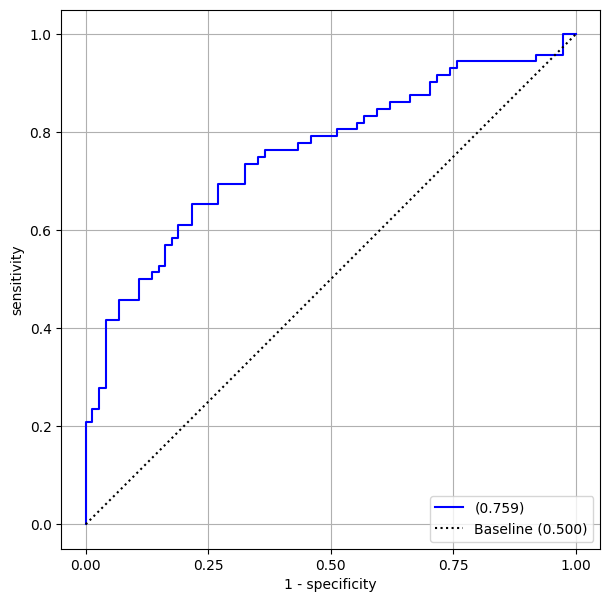

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# create a roc curve
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targets.astype(int), outputs)
score = roc_auc_score(targets.astype(int), outputs)

# find the threshold such that sensitivity ~= Choc value of 0.76 (validation set)
idx = np.argmin(np.abs(tpr - CHOC_sensitivity))
decision_threshold = eps[idx]
print(f"Threshold: {decision_threshold:0.3f}")

plt.plot(fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.plot(grid, grid, 'k:', label='Baseline (0.500)')
plt.gca().set_aspect(1)
plt.legend(loc=4)
plt.grid()

plt.xlabel("1 - specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22

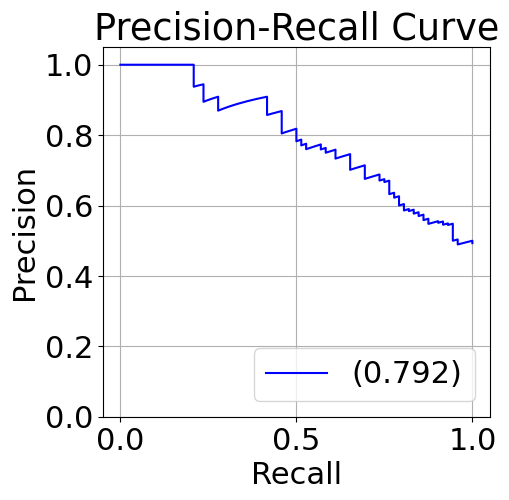

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# create a prec-rec curve
precision, recall, thresholds = precision_recall_curve(targets.astype(int), outputs)
ap = average_precision_score(targets.astype(int), outputs)

plt.plot(recall, precision, 'b-', label=f"({ap:0.3f})")
plt.ylim(0,1.05)
plt.gca().set_aspect(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc=4)
plt.show()


In [12]:
# sensitivity and specificity at max f1
from sklearn.metrics import confusion_matrix
y_pred = outputs >= decision_threshold
y_true = targets.astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() 

sensitivity = tp / (tp + fn) # true positives / positives
specificity = tn / (tn + fp) # true negatives / negatives
ppv = tp / (tp + fp) # true positives / predicted positives
npv = tn / (tn + fn) # true negatives / predicted negatives

sensitivity, specificity, ppv, npv


(0.7638888888888888, 0.6351351351351351, 0.6707317073170732, 0.734375)

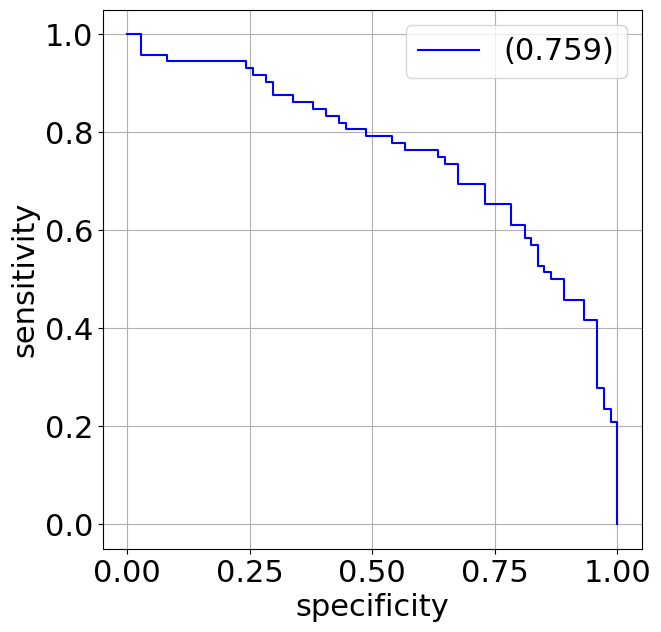

In [13]:
# sensitivity vs. specificity
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targets.astype(int), outputs)
score = roc_auc_score(targets.astype(int), outputs)

plt.plot(1-fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.gca().set_aspect(1)
plt.legend(loc=1)
plt.grid()

plt.xlabel("specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22